In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from os import listdir
from os.path import isfile, join

import shutil

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<AxesSubplot:>

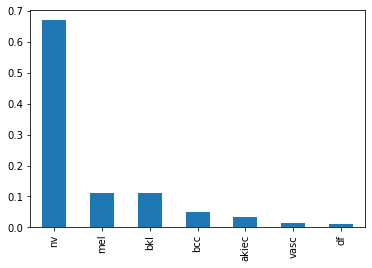

In [2]:
df = pd.read_csv('data/HAM10000_metadata.csv')
df.head()

filtered = df.iloc[list(range(0, len(df), 2)),:].copy().reset_index(drop = True)
filtered.head()

filtered['dx'].value_counts(normalize = True).plot(kind = 'bar')

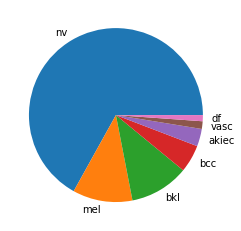

In [3]:
filtered['dx'].value_counts(normalize = True).plot(kind = 'pie')
plt.ylabel(None)
plt.show()

In [4]:
label_encoding = sorted(list(filtered['dx'].unique()))
label_encoding

#############Enablefor mving files #################

# image_labels = dict(zip(filtered['image_id'], filtered['dx']))

# train_path = 'data/all_images'
# onlyfiles = [f for f in listdir(train_path) if isfile(join(train_path, f))]

# for i in filtered['image_id']:
#     source = train_path + "/" + i + '.jpg'
#     dest = train_path + "/" + image_labels[i] + "/" + i + '.jpg'
# #     print(source)
# #     print(dest)
#     shutil.copy(source, dest)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Data Augmentation (To be explored later)

In [5]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    # preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    # preprocessing.RandomRotation(factor=0.20),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

# NN

## NN creation

In [6]:
tf.device("/gpu:0")

In [7]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=False,
    color_mode = 'rgb',
#     validation_split = 0.2,
#     subset = 'training',
#     seed = 1
)
ds_valid_ = image_dataset_from_directory(
    'data/binary_class',
    labels='inferred',
    label_mode='binary',
    image_size=[600, 450],
    interpolation='nearest',
    batch_size=8,
    shuffle=True,
    color_mode = 'rgb',
#     validation_split = 0.2,
#     subset = 'validation',
#     seed = 1
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5008 files belonging to 2 classes.
Found 5008 files belonging to 2 classes.


In [8]:
model3 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    #layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon = 0.01)
model3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d (Conv2D)              (None, 596, 446, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 298, 223, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 298, 223, 32)      224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 294, 219, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 147, 109, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 147, 109, 32)     

In [9]:
save = 0

In [10]:
if save == 1:
    history = model3.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
        class_weight = {0:1, 1:7}
    )
    model3.save_weights('model3')
else:
    model3.load_weights('model3')

In [11]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()

In [12]:
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

In [13]:
temp_train = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

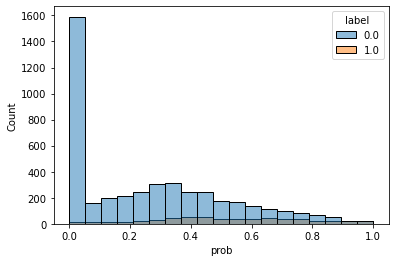

In [14]:
sns.histplot(data = temp_train, x = 'prob', hue = 'label')
plt.show()

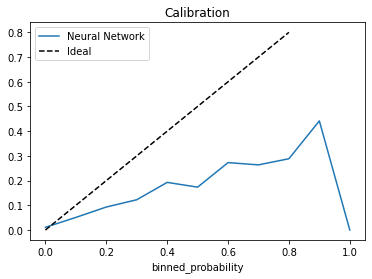

In [15]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp_train['binned_probability'] = temp_train['prob'].apply(create_bins)
temp_train.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

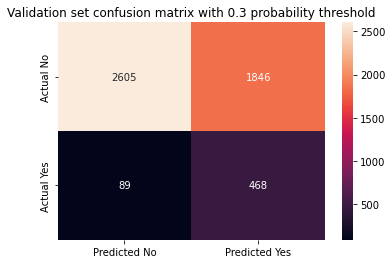

In [16]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

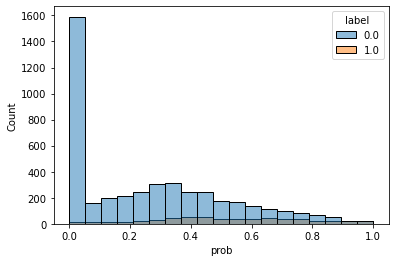

In [17]:
predictions = []
labels =  []
for x, y in ds_valid:
    predictions = predictions + model3.predict(x).tolist()
    labels = labels + y.numpy().tolist()
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]
temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})
sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

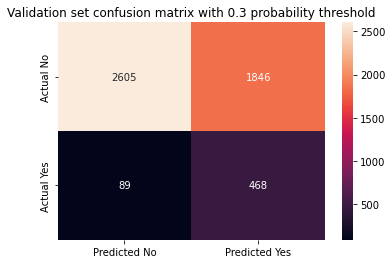

In [18]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

## Introducing Cascading

In [19]:
temp = temp_train.copy()

In [20]:
no_class = 'data/binary_class/0'
no_class_names = [f for f in listdir(no_class) if isfile(join(no_class, f))]
yes_class = 'data/binary_class/1'
yes_class_names = [f for f in listdir(yes_class) if isfile(join(yes_class, f))]
len(no_class_names+yes_class_names)

5008

In [21]:
temp['image_id'] = no_class_names+yes_class_names
temp['image_id'] = temp['image_id'].str.split('.', expand = True)[0]
temp.head()

,prob,label,binned_probability,image_id
0,4.116420e-01,0.0,0.4,ISIC_0024312
1,1.612795e-10,0.0,0.0,ISIC_0024322
2,9.179620e-11,0.0,0.0,ISIC_0024326
3,3.915620e-01,0.0,0.3,ISIC_0024327
4,2.394158e-01,0.0,0.2,ISIC_0024328


In [22]:
cascade = filtered.merge(temp, on = 'image_id')
cascade.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,prob,label,binned_probability
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.146128,0.0,0.1
1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.100011,0.0,0.1
2,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.554906,0.0,0.5
3,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,0.290073,0.0,0.2
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,0.137339,0.0,0.1


In [23]:
X = cascade[['dx_type', 'age', 'sex', 'localization', 'prob']].copy()
y = cascade['label'].copy()
X = pd.concat([
    pd.get_dummies(X['dx_type'], drop_first = True, prefix = 'dx_type'), 
    X.drop(columns = ['dx_type'])
          ], axis = 1 )
X = pd.concat([
    pd.get_dummies(X['sex'], drop_first = True, prefix = 'sex'), 
    X.drop(columns = ['sex'])
          ], axis = 1 )
X = pd.concat([
    pd.get_dummies(X['localization'], drop_first = True, prefix = 'localization'), 
    X.drop(columns = ['localization'])
          ], axis = 1 )

In [24]:
X.head()

,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,...,localization_trunk,localization_unknown,localization_upper extremity,sex_male,sex_unknown,dx_type_consensus,dx_type_follow_up,dx_type_histo,age,prob
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,80.0,0.146128
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,80.0,0.100011
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,75.0,0.554906
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,60.0,0.290073
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,70.0,0.137339


In [25]:
X[X.isna().any(axis=1)]

,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,...,localization_trunk,localization_unknown,localization_upper extremity,sex_male,sex_unknown,dx_type_consensus,dx_type_follow_up,dx_type_histo,age,prob
484,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,NaN,0.209477
485,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,NaN,0.611206
486,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,NaN,0.240352
487,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,NaN,0.599737
489,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,NaN,0.485554
943,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,NaN,0.207276
3779,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0.208215
3981,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,NaN,0.919556
4205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,0.378683
4693,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,NaN,0.201579


In [26]:
X['age'].fillna(X['age'].median(), inplace = True)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, 
                                                    random_state = 42, stratify = y, 
                                                    test_size = 0.2
                                                   )

In [28]:
rf = RandomForestClassifier(class_weight = {0:1, 1:7},
                            ccp_alpha = 0.0025)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.7321517723414878
0.7245508982035929


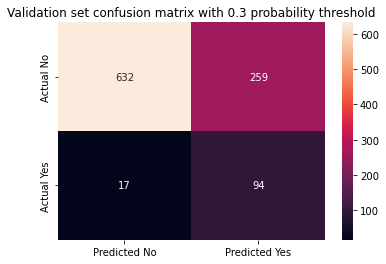

In [29]:
df = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=rf.predict(X_test)),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

<AxesSubplot:>

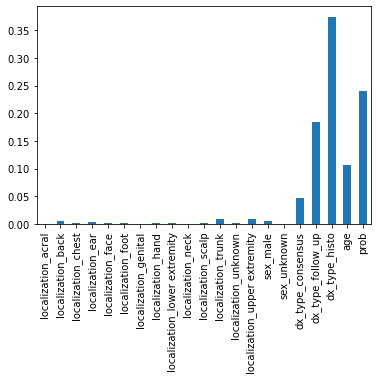

In [30]:
pd.Series(rf.feature_importances_, index = rf.feature_names_in_).plot(kind = 'bar')

In [60]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(rf.predict_proba, shap.sample(X_train[:1000], 100))
shap_values = explainer.shap_values(X_test, nsamples=40)

  0%|          | 0/1002 [00:00<?, ?it/s]

In [61]:
shap.initjs()
n = 23
shap.force_plot(explainer.expected_value[0], shap_values[0][n,:], X_test.iloc[n,:])

## Explainable AI - Understanding what CNN layer is actually extracting

In [11]:
ds_train.list_files('data/binary_class')

<ShuffleDataset shapes: (), types: tf.string>

In [12]:
for x,y in ds_valid:
    break
x = x.numpy()

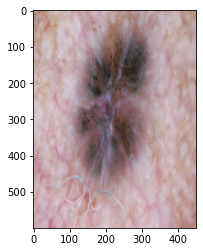

In [13]:
plt.imshow(x[0])

In [14]:
batch_norm_1 = model3.layers[0]
first_conv_1 = model3.layers[1]
max_pool_1 = model3.layers[2]
batch_norm_2 = model3.layers[3]
first_conv_2 = model3.layers[4]
max_pool_2 = model3.layers[5]
batch_norm_3 = model3.layers[6]
first_conv_3 = model3.layers[7]
max_pool_3 = model3.layers[8]
batch_norm_4 = model3.layers[9]
first_conv_4 = model3.layers[10]

In [15]:
batch_norm_out_1 = batch_norm_1(x)
CNN_layer_output_1 = first_conv_1(batch_norm_out_1)
max_pool_output_1 = max_pool_1(CNN_layer_output_1)
batch_norm_out_2 = batch_norm_2(max_pool_output_1)
CNN_layer_output_2 = first_conv_2(batch_norm_out_2)
max_pool_output_2 = max_pool_2(CNN_layer_output_2)
batch_norm_out_3 = batch_norm_3(max_pool_output_2)
CNN_layer_output_3 = first_conv_3(batch_norm_out_3)
max_pool_output_3 = max_pool_3(CNN_layer_output_3)
batch_norm_out_4 = batch_norm_4(max_pool_output_3)
CNN_layer_output_4 = first_conv_4(batch_norm_out_4)

### layer 1

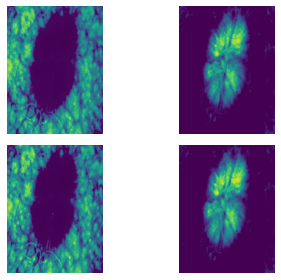

In [24]:
current_layer_output = CNN_layer_output_1[0]
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2][i%2].imshow(current_layer_output[:,:,i])
    ax[i//2][i%2].axis('off')
plt.tight_layout()

## layer 2

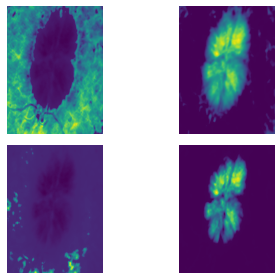

In [23]:
current_layer_output = CNN_layer_output_2[0]
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2][i%2].imshow(current_layer_output[:,:,i])
    ax[i//2][i%2].axis('off')
plt.tight_layout()

## layer 3

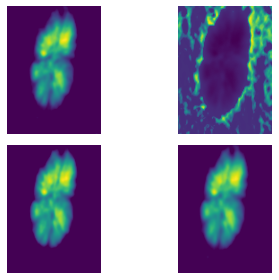

In [25]:
current_layer_output = CNN_layer_output_3[0]
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2][i%2].imshow(current_layer_output[:,:,i])
    ax[i//2][i%2].axis('off')
plt.tight_layout()

## Layer 4

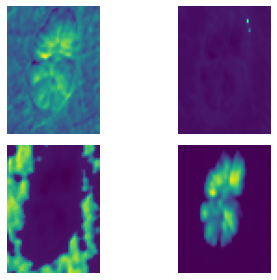

In [26]:
current_layer_output = CNN_layer_output_4[0]
fig, ax = plt.subplots(2, 2)
for i in range(4):
    ax[i//2][i%2].imshow(current_layer_output[:,:,i])
    ax[i//2][i%2].axis('off')
plt.tight_layout()

# Model 4

In [41]:
model4 = keras.Sequential([
    layers.InputLayer(input_shape=[600, 450, 3]),
    
    # Block One
    # layers.BatchNormalization(renorm=True),
#     layers.Rescaling(scale = 1./255),
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=9, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=32, kernel_size=7, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block Four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=16, kernel_size=5, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),
    
    # Block four
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation=layers.LeakyReLU(alpha=0.01)),
    
    # output
    layers.Dense(1, activation='sigmoid'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 600, 450, 3)       21        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 592, 442, 32)      7808      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 296, 221, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 296, 221, 32)      224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 290, 215, 32)      50208     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 145, 107, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 145, 107, 32)     

In [ ]:
save = 1

In [ ]:
if save == 1:
    history = model4.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1,
        use_multiprocessing=True,
        class_weight = {0:1, 1:7}
    )
    model4.save_weights('model4')
else:
    model4.load_weights('model4')


In [ ]:
predictions = []
labels =  []
for x, y in ds_train:
    predictions = predictions + model4.predict(x).tolist()
    labels = labels + y.numpy().tolist()
    
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

In [ ]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

In [ ]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

In [ ]:
predictions = []
labels =  []
for x, y in ds_valid:
    predictions = predictions + model4.predict(x).tolist()
    labels = labels + y.numpy().tolist()
    
predictions = [x[0] for x in predictions]
labels = [x[0] for x in labels]

temp = pd.DataFrame({
    'prob' : predictions,
    'label':labels
})

sns.histplot(data = temp, x = 'prob', hue = 'label')
plt.show()

In [ ]:
nbins = 10
bins = list(range(0, 100, int(100 / nbins)))
bins = [b/100 for b in bins]

def create_bins(p):
    for i in range(nbins):
        if i == nbins - 1:
            if (p > bins[i]) and (p < 1):
                return bins[i]
            else:
                return 1
        if (p > bins[i]) and (p < bins[i+1]):
            return bins[i]
    return 0

temp['binned_probability'] = temp['prob'].apply(create_bins)
temp.groupby('binned_probability')['label'].mean().plot(label = 'Neural Network')
plt.plot([0, 0.8] , [0, 0.8], 'k--',label = 'Ideal')
plt.title("Calibration")
plt.legend()
plt.show()

In [ ]:
predicted_class = [1 if p > 0.3 else 0 for p in predictions]
confusion_matrix(y_true=labels, y_pred=predicted_class)
df = pd.DataFrame(confusion_matrix(y_true=labels, y_pred=predicted_class),
             columns = ['Predicted No', 'Predicted Yes'],
             index = ['Actual No', 'Actual Yes'],)
sns.heatmap(df, annot = True, fmt = 'd')
plt.title("Validation set confusion matrix with 0.3 probability threshold")
plt.show()

In [ ]:
keras.backend.clear_session()